In [10]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score

# Style
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# Correct paths (since notebook is in /notebooks)
MODELS = Path('../models')
REPORTS = Path('../reports')
DATA = Path('../data/processed')

REPORTS.mkdir(exist_ok=True, parents=True)

In [16]:
# %%
# ========================
# 2. Load Models and Data
# ========================
clf = joblib.load(MODELS / 'fertilizer_type_model.pkl')
reg = joblib.load(MODELS / 'fertilizer_quantity_model.pkl')

train = pd.read_csv(DATA / 'train.csv')
val = pd.read_csv(DATA / 'val.csv')
test = pd.read_csv(DATA / 'test.csv')

print(f"Data loaded — Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")

Data loaded — Train: (722, 19), Val: (128, 19), Test: (150, 19)


📊 Classification Report:
               precision    recall  f1-score   support

     Compost       0.35      0.19      0.25        36
         DAP       0.25      0.17      0.20        35
       Mixed       0.17      0.22      0.19        23
      Potash       0.29      0.34      0.31        47
        Urea       0.05      0.11      0.07         9

    accuracy                           0.23       150
   macro avg       0.22      0.21      0.20       150
weighted avg       0.26      0.23      0.24       150



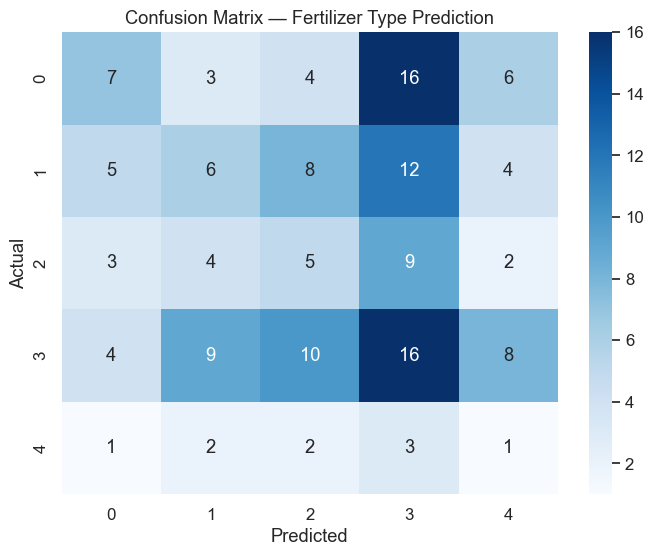

In [19]:
# %%
# ========================
# 3. Classification Evaluation (Fixed)
# ========================
def add_rule_features(df):
    """Recreate the same engineered features used during training."""
    df = df.copy()
    df['High_N_Need'] = (df['Nitrogen_Level'] < 100).astype(int)
    df['High_P_Need'] = (df['Phosphorus_Level'] < 30).astype(int)
    df['High_K_Need'] = (df['Potassium_Level'] < 100).astype(int)
    return df

# Prepare data
X_test_clf = test.drop(['Fertilizer_Type','Recommended_Quantity_kg_per_acre'], axis=1)
y_test_clf = test['Fertilizer_Type']

# ✅ Add engineered features to match model training
X_test_clf = add_rule_features(X_test_clf)

# Predict
preds_clf = clf.predict(X_test_clf)

# Report
print('📊 Classification Report:\n', classification_report(y_test_clf, preds_clf))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, preds_clf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — Fertilizer Type Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Mean Absolute Error: 46.02
R² Score: -0.012


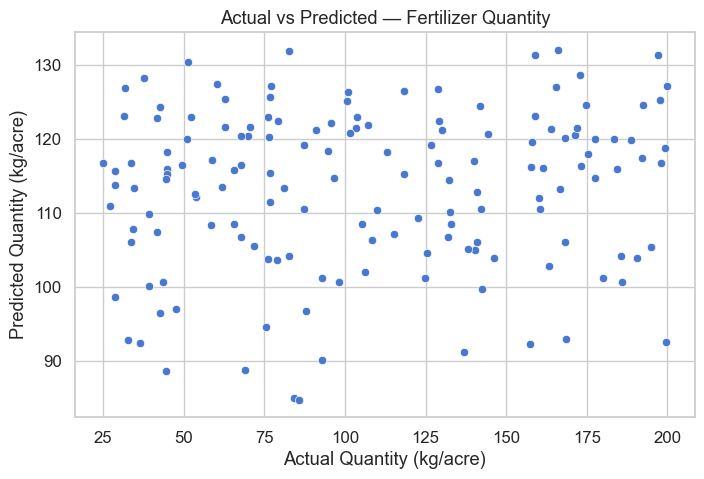

In [20]:
# %%
# ========================
# 4. Regression Evaluation
# ========================
X_test_reg = X_test_clf.copy()
y_test_reg = test['Recommended_Quantity_kg_per_acre']

preds_reg = reg.predict(X_test_reg)

mae = mean_absolute_error(y_test_reg, preds_reg)
r2 = r2_score(y_test_reg, preds_reg)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'R² Score: {r2:.3f}')

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_reg, y=preds_reg)
plt.title('Actual vs Predicted — Fertilizer Quantity')
plt.xlabel('Actual Quantity (kg/acre)')
plt.ylabel('Predicted Quantity (kg/acre)')
plt.show()

In [21]:
# %%
# ========================
# 5. Save Evaluation Report
# ========================
report = {
    'Classification_Accuracy': (preds_clf == y_test_clf).mean(),
    'Regression_MAE': mae,
    'Regression_R2': r2
}
report_df = pd.DataFrame([report])
report_df.to_csv(REPORTS / 'final_evaluation.csv', index=False)
print('✅ Final evaluation metrics saved to reports/final_evaluation.csv')
report_df

✅ Final evaluation metrics saved to reports/final_evaluation.csv


,Classification_Accuracy,Regression_MAE,Regression_R2
0,0.233333,46.015249,-0.012085


In [28]:
# %%
# ========================
# 6. Generate Model Card
# ========================
model_card = f"""
# Model Card — Smart Fertilizer Recommender

**Date:** Auto-generated

**Models:**
- Classifier: RandomForestClassifier (fertilizer type)
- Regressor: RandomForestRegressor (fertilizer quantity)

**Performance:**
- Accuracy: {report['Classification_Accuracy']:.2f}
- MAE: {report['Regression_MAE']:.2f}
- R²: {report['Regression_R2']:.2f}

**Training Data:** 1000 samples, 15 features  
**Input Fields:** Crop Type, Soil pH, NPK levels, Region, Plant Age, etc.  
**Output:** Fertilizer type + recommended quantity  

**Usage:** Intended for smallholder farmers. The model combines expert rules and ML-based insights.  

**Limitations:** Performance may vary for unseen soil types or rare crops. Retrain annually with new data.
"""

with open(REPORTS / 'model_card.md', 'w', encoding='utf-8') as f:
    f.write(model_card)

print("✅ Model card saved at reports/model_card.md")

✅ Model card saved at reports/model_card.md


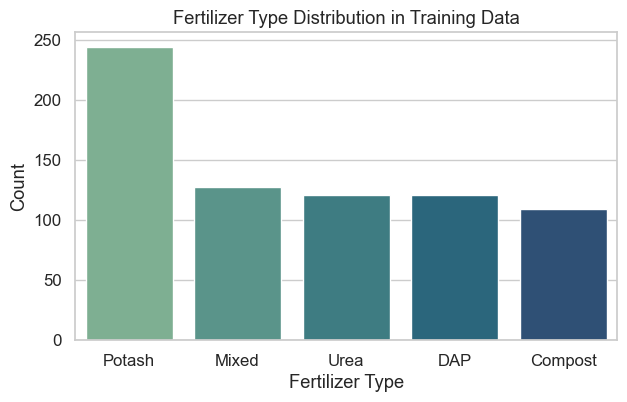

✅ Visualization complete and model evaluation successful!


In [30]:
# %%
# ========================
# 7. Extra Visualization — Class Distribution
# ========================
plt.figure(figsize=(7,4))
sns.barplot(
    x=train['Fertilizer_Type'].value_counts().index,
    y=train['Fertilizer_Type'].value_counts().values,
    hue=train['Fertilizer_Type'].value_counts().index,
    palette='crest',
    legend=False
)

plt.title('Fertilizer Type Distribution in Training Data')
plt.ylabel('Count')
plt.xlabel('Fertilizer Type')
plt.show()

print("✅ Visualization complete and model evaluation successful!")

In [31]:
train['Fertilizer_Type'].value_counts(normalize=True)


Fertilizer_Type
Potash     0.33795
Mixed      0.17590
Urea       0.16759
DAP        0.16759
Compost    0.15097
Name: proportion, dtype: float64